Ever since I jumped into the deep learning world, wrestling with hyperparameters has been my main event. Sure, tools like Optuna and GridSearchCV are game changers for regular machine learning models, but when it comes to LSTMs, I've been left wanting more.

So, in this notebook, I've got a clear mission: to cook up a tool that not only tunes the parameters of an LSTM model but also lays out the predictions in a neat visual. Here's a breakdown of the functions I've put together:

<div align="center">

## **Function Descriptions**

</div>

---

<div style="background-color: #f9f9f9; padding: 20px; border: 1px solid #e0e0e0; border-radius: 5px;">

### <span style="color: #3498db; font-size: 20px;">create_dataset:</span>
The `create_dataset` function is specifically designed to handle time-series data for neural network training. When predicting in time-series contexts, using past data points to forecast future ones is standard. Depending on the `look_back` parameter, this function takes the main dataset and churns out overlapping sequences or windows. For instance, given a `look_back` of 3, one might observe input sequences like `[1, 2, 3]`, `[2, 3, 4]`, and `[3, 4, 5]` to prognosticate the subsequent values `4`, `5`, and `6` respectively.

</div>

---

<div style="background-color: #f9f9f9; padding: 20px; border: 1px solid #e0e0e0; border-radius: 5px;">

### <span style="color: #3498db; font-size: 20px;">Keras_RMSE:</span>
`Keras_RMSE` computes the Root Mean Squared Error (RMSE) between the predicted and actual values. A pivotal metric in numerous regression tasks, RMSE sheds light on the error magnitude inherent in model predictions. Its design, based on square roots, ensures heightened sensitivity to large errors, making it an invaluable metric for many regression tasks.

</div>

---

<div style="background-color: #f9f9f9; padding: 20px; border: 1px solid #e0e0e0; border-radius: 5px;">

### <span style="color: #3498db; font-size: 20px;">LSTM_Regression_Tester:</span>
Acting as a comprehensive suite for LSTM-driven regression, the `LSTM_Regression_Tester` function takes the helm. LSTM, standing for Long Short-Term Memory, is a recurrent neural network type fine-tuned for time-series and sequence data. Initiating with data scaling to ensure uniform value range (essential for optimal neural network operations), this function then crafts the data for time-series predictions, defines the LSTM architecture, and plunges into the training phase, optimizing weights based on the data at hand.

</div>

---

<div style="background-color: #f9f9f9; padding: 20px; border: 1px solid #e0e0e0; border-radius: 5px;">

### <span style="color: #3498db; font-size: 20px;">regression_results:</span>
Once training wraps up, assessing model prowess becomes paramount. Enter the `regression_results` function. It spawns a DataFrame saturated with pivotal performance metrics. Users gain direct insights into the RMSE across training, validation, and testing datasets, enabling comprehensive model evaluation across diverse data partitions. Moreover, the function details other training facets, streamlining tracking and contrasting between different model runs.

</div>

---

<div style="background-color: #f9f9f9; padding: 20px; border: 1px solid #e0e0e0; border-radius: 5px;">

### <span style="color: #3498db; font-size: 20px;">plot_loss_regression:</span>
Diving deeper into performance metrics, the `plot_loss_regression` function thrives. Offering graphical insights into model behavior, this function meticulously plots both training and validation loss alongside RMSE values for every epoch. Such visual aids allow rapid identification of potential overfitting or underfitting scenarios, ensuring users stay informed throughout the model's lifecycle.

</div>

---

<div style="background-color: #f9f9f9; padding: 20px; border: 1px solid #e0e0e0; border-radius: 5px;">

### <span style="color: #3498db; font-size: 20px;">plot_predictions:</span>
The `plot_predictions` function, an epitome of evaluative clarity, vividly juxtaposes predicted outputs against actual ground truths. Actual prices are showcased via bar charts, while their predicted counterparts unfurl through line graphs. Such a visualization mode empowers users to pinpoint areas of excellence or those demanding improvement. For classification enthusiasts, this function also spotlights erroneous predictions, amplifying clarity on potential classification pitfalls.

</div>



In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
import time

from sklearn import preprocessing as pre
from sklearn import metrics as met

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import yfinance as yf

def create_dataset(X, y, look_back=1):
    
    """
    Creates a time-series dataset by windowing the data.
    
    Parameters:
    - X: Feature data
    - y: Target data
    - look_back (int): The window size for creating the dataset. Default is 1.
    
    Returns:
    - X_data: Windowed feature data
    - y_data: Windowed target data
    """
    
    X_data, y_data = [], []
    for i in range(len(X) - look_back):
        X_data.append(X[i:(i + look_back)])
        y_data.append(y[i + look_back])
    return np.array(X_data), np.array(y_data)

def Keras_RMSE(y_true, y_pred):
    
    """
    Calculates Root Mean Squared Error (RMSE) for predictions.
    
    Parameters:
    - y_true: True target values
    - y_pred: Predicted values
    
    Returns:
    - RMSE value
    """
    
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def LSTM_Regression_Tester(df, look_back=60, test_coef=10, val_coef = 4, dropout = 0.2, epochs=50, early_stopping=True, num_layers=2, units = 50, optimizer = 'rmsprop', activation_function='tanh', batch_size = 32):
    
    """
    Trains an LSTM neural network for regression tasks.
    
    Parameters:
    - df (DataFrame): DataFrame containing the data
    - look_back (int): Window size for the data. Default is 60.
    - test_coef (int): Coefficient to determine test set size. Default is 10.
    - val_coef (int): Coefficient to determine validation set size. Default is 4.
    - dropout (float): Dropout rate for regularization. Default is 0.2.
    - epochs (int): Number of training epochs. Default is 50.
    - early_stopping (bool): If true, use early stopping during training. Default is True.
    - num_layers (int): Number of LSTM layers. Default is 2.
    - units (int): Number of neurons in each LSTM layer. Default is 50.
    - optimizer (str): Optimizer to use during training. Default is 'rmsprop'.
    - activation_function (str): Activation function for LSTM layers. Default is 'tanh'.
    - batch_size (int): Size of each training batch. Default is 32.
    
    Returns:
    - regressor: Trained LSTM model
    - X_test: Test data
    - scaler_y: Scaler object for the target variable
    - y_test[look_back:]: Shifted test target data
    - elapsed_time: Time taken to train the model
    - history: Training history object
    """
    
    start_time = time.time()

    if len(df.columns) > 1:
        X = df.drop('close', axis=1).values
        n_cols = X.shape[1]
    else:
        X = df.values
        n_cols = 1

    y = df['close'].values

    X_val, X_test = X[-1 * val_coef * look_back * test_coef:-2 * look_back * test_coef], X[-2 * look_back * test_coef:]
    y_val, y_test = y[-1 * val_coef * look_back * test_coef:-2 * look_back * test_coef], y[-2 * look_back * test_coef:]

    X_train, y_train = X[:-2 * look_back * test_coef], y[:-2 * look_back * test_coef]

    scaler_X = pre.MinMaxScaler()
    scaler_y = pre.MinMaxScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_val = scaler_X.transform(X_val)
    X_test = scaler_X.transform(X_test)

    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_val = scaler_y.transform(y_val.reshape(-1, 1))
    y_test_transformed = scaler_y.transform(y_test.reshape(-1, 1))

    X_train, y_train = create_dataset(X_train, y_train, look_back)
    X_val, y_val = create_dataset(X_val, y_val, look_back)
    X_test, y_test_transformed = create_dataset(X_test, y_test_transformed, look_back)

    regressor = Sequential()

    regressor.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], n_cols), activation=activation_function))
    regressor.add(Dropout(dropout))
    
    for layer in range(num_layers - 1):
        regressor.add(LSTM(units=units, return_sequences=True if layer < num_layers - 2 else False, activation=activation_function))
        regressor.add(Dropout(dropout))

    regressor.add(Dense(units=1))

    regressor.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[Keras_RMSE])

    callbacks_list = []

    if early_stopping:
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=0, restore_best_weights=True)
        callbacks_list.append(early_stop)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=0, min_delta=0.0001)
    callbacks_list.append(reduce_lr)

    history = regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=0)

    end_time = time.time()
    elapsed_time = end_time - start_time

    return regressor, X_test, scaler_y, y_test[look_back:], round(elapsed_time, 2), history

def regression_results(epochs, elapsed_time, train_loss, train_rmse, val_loss, val_rmse, y_test, predicted_price):
    
    """
    Generates a DataFrame containing regression results.
    
    Parameters:
    - epochs (int): Number of training epochs.
    - elapsed_time (float): Time taken to train the model.
    - train_loss (float): Loss value on the training set.
    - train_rmse (float): RMSE on the training set.
    - val_loss (float): Loss value on the validation set.
    - val_rmse (float): RMSE on the validation set.
    - y_test (array-like): True target values for test set.
    - predicted_price (array-like): Predicted values for test set.
    
    Returns:
    - df (DataFrame): DataFrame with regression metrics.
    """
    
    test_rmse = round(met.mean_squared_error(y_test, predicted_price, squared=False), 2)
    df = pd.DataFrame({"epochs": [epochs], "elapsed time": [round(elapsed_time,2)], "test RMSE":[round(test_rmse,2)],\
                       "train loss": [train_loss], "validation loss": [val_loss], "train RMSE": [train_rmse],\
                       "validation RMSE": [val_rmse]})
    return df

def plot_loss_regression(train_loss, train_rmse, val_loss, val_rmse):
    
    """
    Plots the training and validation loss and RMSE values for each epoch.
    
    Parameters:
    - train_loss (list): Training loss values.
    - train_rmse (list): Training RMSE values.
    - val_loss (list): Validation loss values.
    - val_rmse (list): Validation RMSE values.
    
    Returns:
    - None (Displays a plot)
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    axs[0].plot(train_loss, color='b', label='Training Loss')
    axs[0].plot(val_loss, color='r', label='Validation Loss')
    axs[0].set_title("Loss curves")
    axs[0].legend(loc='best', shadow=True)
    axs[1].plot(train_rmse, color='b', label='Training RMSE')
    axs[1].plot(val_rmse, color='r', label='Validation RMSE')
    axs[1].set_title("RMSE curves")
    axs[1].legend(loc='best', shadow=True)
    plt.show()
    
def plot_predictions(df, predicted, ticker, epochs, duration, batch_size, activation_function, num_layers, classification = False):
    
    """
    Visualizes the actual versus predicted prices using bar charts and line graphs.
    
    Parameters:
    - df (DataFrame): DataFrame containing the original data.
    - predicted (list): Predicted values from the model.
    - ticker (str): Stock ticker symbol.
    - epochs (int): Number of training epochs.
    - duration (float): Time taken to train the model.
    - batch_size (int): Size of each training batch.
    - activation_function (str): Activation function for LSTM layers.
    - num_layers (int): Number of LSTM layers.
    - classification (bool): If true, indicates this is a classification task. Default is False.
    
    Returns:
    - None (Displays a plot)
    """
    
    fig, ax = plt.subplots(figsize=(12, 5))
    bar_df = df[-len(predicted):]
    color = ["green" if close_price >= open_price else "red" for close_price, open_price in zip(bar_df["close"], bar_df["open"])]
    candlesticks = ax.bar(x=bar_df.index, height=np.abs(bar_df["open"] - bar_df["close"]), bottom=np.min((bar_df["open"], bar_df["close"]), axis=0), color=color, width=0.6, align='center')
    ax.vlines(x=bar_df.index, ymin=bar_df["low"], ymax=bar_df["high"], color=color)
    
    if classification:
        actual = (df['close'].rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])[-len(predicted):]).astype(int).values
        errors = [i for i, (a, c) in enumerate(zip(actual, predicted)) if a != c]
        for err in errors:
            ax.axvline(x=bar_df.index[err], color='blue', linestyle='dotted', label='Misclassification' if 'Misclassification' not in [l.get_label() for l in ax.lines] else "")
    else:
        ax.plot(bar_df.index, predicted, color='blue', label=f'Predicted {ticker} Closing Price', linewidth=1)
    ax.legend()
    ax.set_title(f'# of Epochs: {epochs}, Computation time: {duration} seconds, Batch Size: {batch_size}, Activation Function: {activation_function}, # of Layers: {num_layers}', fontsize=10)
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{ticker} Closing Price')
    plt.tight_layout()
    plt.show()

Now will download the NASDAQ Composite index historical prices to test the performace of the code.

In [21]:
nasdaq = yf.Ticker("^IXIC")
df = nasdaq.history(period="max")
df.columns = ["open", "high", "low", "close", "volume", "dividends", "spilts"]
df.tail()

,open,high,low,close,volume,dividends,spilts
Date,,,,,,,
2023-08-07 00:00:00-04:00,13972.450195,13997.150391,13864.919922,13994.400391,4892330000,0.0,0.0
2023-08-08 00:00:00-04:00,13875.450195,13899.740234,13769.339844,13884.320312,5284550000,0.0,0.0
2023-08-09 00:00:00-04:00,13897.610352,13898.540039,13698.389648,13722.019531,5591360000,0.0,0.0
2023-08-10 00:00:00-04:00,13818.250000,13947.160156,13686.509766,13737.990234,5299080000,0.0,0.0
2023-08-11 00:00:00-04:00,13633.650391,13720.330078,13609.980469,13644.849609,4638880000,0.0,0.0


The functions I've implemented enable testing of several components of the model, including:

- look_back (int): Specifies the window size for the data.
- test_coef (int): A coefficient determining the test set size.
- val_coef (int): A coefficient deciding the validation set size.
- dropout (float): The dropout rate used for regularization.
- epochs (int): The number of training epochs.
- early_stopping (bool): If set to true, early stopping will be employed during training.
- num_layers (int): The number of LSTM layers in the model.
- units (int): The number of neurons present in each LSTM layer.
- optimizer (str): The optimizer chosen for training.
- activation_function (str): The activation function utilized for the LSTM layers.
- batch_size (int): Specifies the size of each training batch.

Starting off, I'm just using the close price for my predictions.

After a ton of testing, I've found a setup that seems to work best for predicting the NASDAQ Composite Price, and that's with just the close price in play. If you come across a better mix of settings or have some cool insights, give me a shout! I'm always up for swapping ideas and making things better.

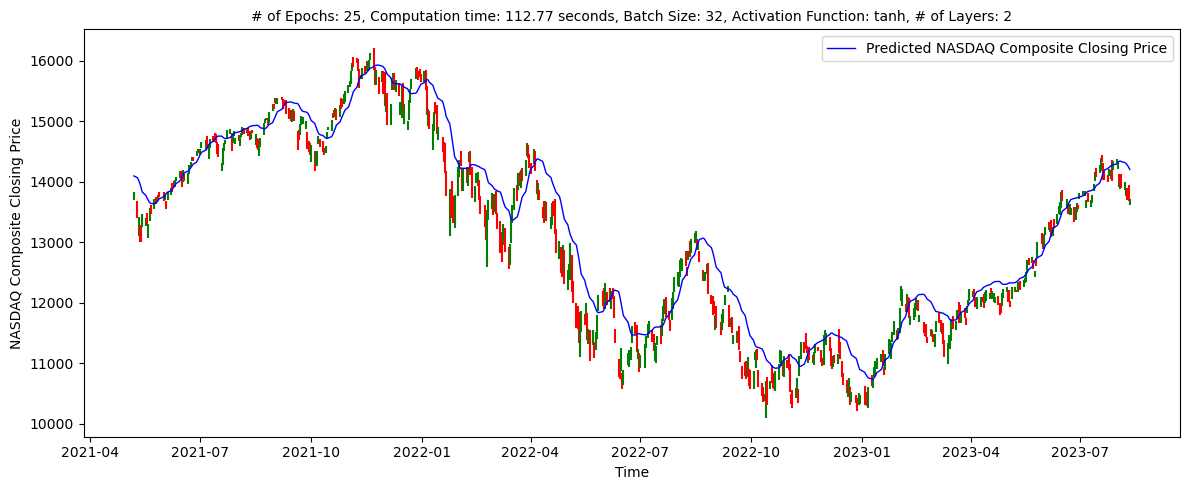

epochs,elapsed time,test RMSE,train loss,validation loss,train RMSE,validation RMSE
25,112.770000,441.240000,"[0.0006713432958349586, 0.00034695101203396916, 0.00026839616475626826, 0.00025155310868285596, 0.00021468492923304439, 0.00019855193386320025, 0.0001955076731974259, 0.0001274823007406667, 0.0001266472681891173, 0.00012286804849281907, 0.00012293786858208477, 0.00011915090726688504]","[0.0059036798775196075, 0.00012498254363890737, 0.00017140274576377124, 0.00041748807416297495, 0.0015084397746250033, 0.0012612727005034685, 0.00011534159420989454, 9.403625881532207e-05, 6.971153925405815e-05, 8.146371692419052e-05, 7.532235758844763e-05, 7.206084410427138e-05]","[0.0217459574341774, 0.017044657841324806, 0.015253978781402111, 0.014768886379897594, 0.013833649456501007, 0.013297789730131626, 0.013095343485474586, 0.010627025738358498, 0.010463090613484383, 0.01039851550012827, 0.01043008640408516, 0.010196034796535969]","[0.06885145604610443, 0.008145375177264214, 0.011381574906408787, 0.01899014785885811, 0.03593854978680611, 0.03346417471766472, 0.009350760839879513, 0.007730815093964338, 0.006226032041013241, 0.00664862897247076, 0.006925836205482483, 0.006333604454994202]"


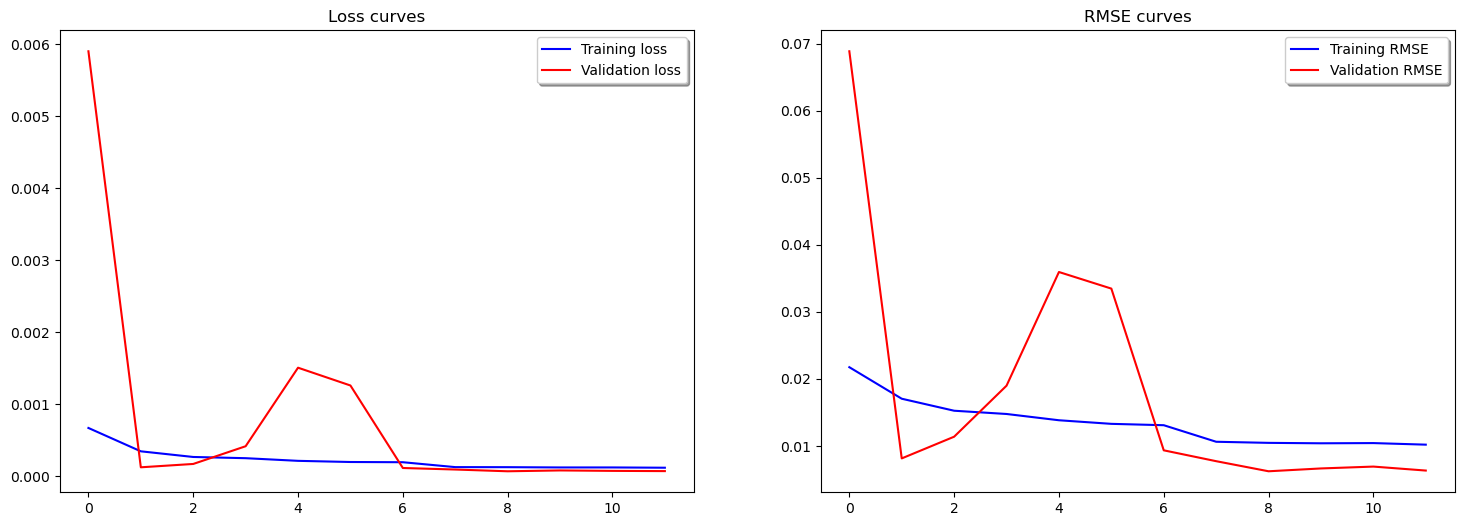

In [19]:
test_df = df[["close"]]

num_layers = 2 
activation_function = "tanh"
optimizer = 'rmsprop'
dropout = 0.1
units = 50
batch_size = 32
look_back = 30
test_coef = 10
val_coef = 16 
epoch = 25

regressor, X_test, scaler_y, y_test, elapsed_time, history = LSTM_Regression_Tester(test_df, 
                                                                                    look_back = look_back, 
                                                                                    test_coef = test_coef,
                                                                                    val_coef = val_coef,
                                                                                    dropout = dropout,
                                                                                    epochs = epoch, 
                                                                                    num_layers=num_layers, 
                                                                                    activation_function=activation_function,
                                                                                    batch_size = batch_size)
predicted_price = regressor.predict(X_test, verbose = 0)
predicted_price = scaler_y.inverse_transform(predicted_price).ravel()
plot_predictions(df,
                 predicted_price,
                 "NASDAQ Composite",
                 epoch,
                 elapsed_time,
                 batch_size,
                 activation_function,
                 num_layers)
display(regression_results(epoch,
                           elapsed_time,
                           history.history['loss'],
                           history.history['Keras_RMSE'],
                           history.history['val_loss'],
                           history.history['val_Keras_RMSE'],
                           y_test,
                           predicted_price).style.hide())
plot_loss_regression(history.history['loss'],
                     history.history['Keras_RMSE'],
                     history.history['val_loss'],
                     history.history['val_Keras_RMSE'])

Next up, I'm curious to see if these same settings hold up for the NYSE predictions. Let's dive in and find out!

In [20]:
nyse = yf.Ticker("^NYA")
df_nyse = nyse.history(period="max")
df_nyse.columns = ["open", "high", "low", "close", "volume", "dividends", "spilts"]
df_nyse.tail()

,open,high,low,close,volume,dividends,spilts
Date,,,,,,,
2023-08-07 00:00:00-04:00,16071.059570,16215.679688,16071.059570,16208.230469,3493920000,0.0,0.0
2023-08-08 00:00:00-04:00,16208.230469,16208.230469,16025.370117,16176.349609,3884910000,0.0,0.0
2023-08-09 00:00:00-04:00,16176.349609,16224.910156,16107.849609,16135.769531,3803100000,0.0,0.0
2023-08-10 00:00:00-04:00,16135.769531,16319.900391,16110.120117,16135.219727,4504370000,0.0,0.0
2023-08-11 00:00:00-04:00,16135.219727,16178.450195,16064.599609,16143.379883,3753290000,0.0,0.0


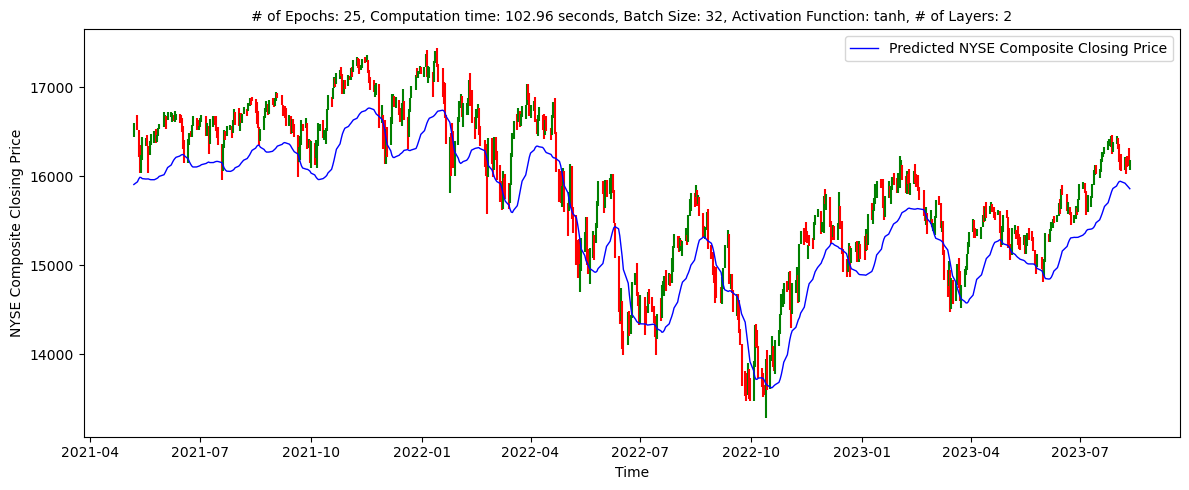

epochs,elapsed time,test RMSE,train loss,validation loss,train RMSE,validation RMSE
25,102.960000,465.420000,"[0.0022555566392838955, 0.0008359379135072231, 0.0006464840262196958, 0.0005266061052680016, 0.0004723894817288965, 0.00042722257785499096, 0.00040499362512491643, 0.00029015273321419954, 0.00028218081570230424, 0.00026762339984998107, 0.0002680078614503145, 0.00026757866726256907]","[0.00032806681701913476, 0.0002125882456311956, 0.00449013477191329, 0.00017112841305788606, 0.00024295970797538757, 0.00021517390268854797, 0.00034171983134001493, 0.00015840209380257875, 0.00014738910249434412, 0.0001514637697255239, 0.00024460788699798286, 0.0002695752482395619]","[0.03805083781480789, 0.026966305449604988, 0.024274632334709167, 0.02186245284974575, 0.020730555057525635, 0.019903514534235, 0.0192883163690567, 0.01650533825159073, 0.016304805874824524, 0.015884194523096085, 0.015941593796014786, 0.015960397198796272]","[0.015471802093088627, 0.012318607419729233, 0.06536899507045746, 0.010923095047473907, 0.01374843344092369, 0.013234586454927921, 0.017204536125063896, 0.010979979299008846, 0.010267451405525208, 0.010236458852887154, 0.014050581492483616, 0.015387571416795254]"


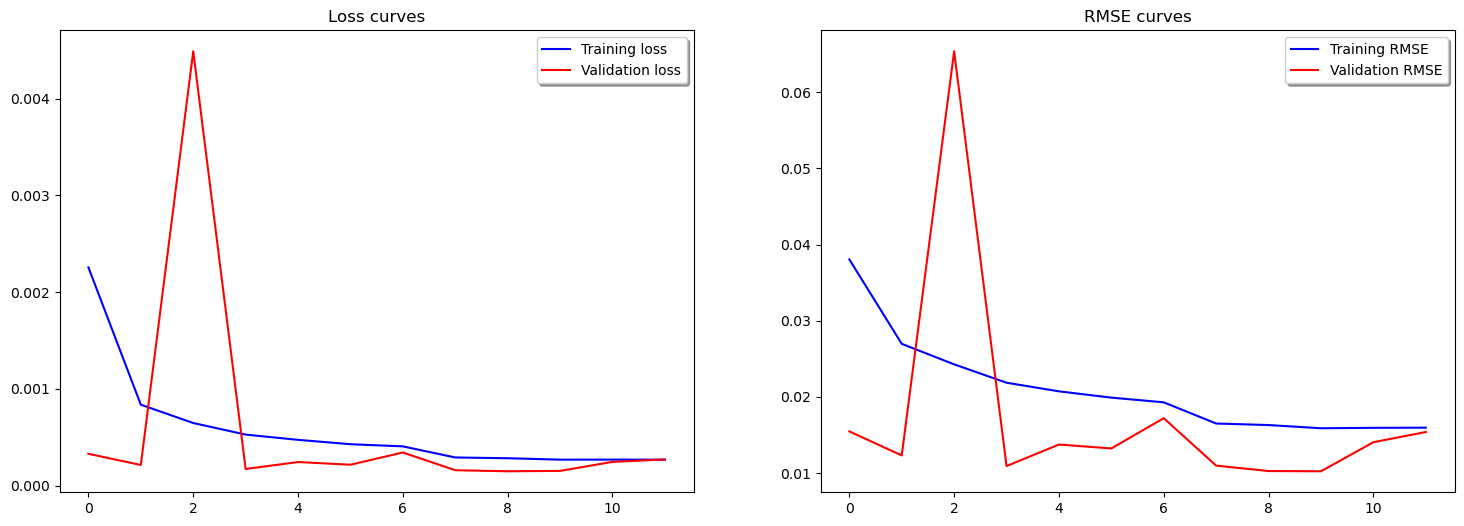

In [23]:
test_df = df_nyse[["close"]]

num_layers = 2 
activation_function = "tanh"
optimizer = 'rmsprop'
dropout = 0.1
units = 50
batch_size = 32
look_back = 30
test_coef = 10
val_coef = 16 
epoch = 25

regressor, X_test, scaler_y, y_test, elapsed_time, history = LSTM_Regression_Tester(test_df, 
                                                                                    look_back = look_back, 
                                                                                    test_coef = test_coef,
                                                                                    val_coef = val_coef,
                                                                                    dropout = dropout,
                                                                                    epochs = epoch, 
                                                                                    num_layers=num_layers, 
                                                                                    activation_function=activation_function,
                                                                                    batch_size = batch_size)
predicted_price = regressor.predict(X_test, verbose = 0)
predicted_price = scaler_y.inverse_transform(predicted_price).ravel()
plot_predictions(df_nyse,
                 predicted_price,
                 "NYSE Composite",
                 epoch,
                 elapsed_time,
                 batch_size,
                 activation_function,
                 num_layers)
display(regression_results(epoch,
                           elapsed_time,
                           history.history['loss'],
                           history.history['Keras_RMSE'],
                           history.history['val_loss'],
                           history.history['val_Keras_RMSE'],
                           y_test,
                           predicted_price).style.hide())
plot_loss_regression(history.history['loss'],
                     history.history['Keras_RMSE'],
                     history.history['val_loss'],
                     history.history['val_Keras_RMSE'])

Next Steps:

- Firstly, I'll be transitioning to classification models with the intent to predict whether the market will rise or fall the following day.
- Concurrently, my goal is to optimize the LSTM Model further, reducing the RMSE. I'm also keen on evaluating the GRU model to see how it compares with LSTM in terms of results.
- Additionally, I'll be exploring traditional time series models like ARIMA to ascertain their predictive capabilities.
- Once I've thoroughly explored and optimized predictions for the indexes, I'll shift focus to predicting individual stock prices.

### I'd genuinely appreciate your thoughts and feedback on this. Please share your insights in the comments below. Your perspective might offer a fresh approach or idea that I haven't considered. Let's collaborate and enrich this discussion together!